# Quantitative Analysis on the Impact of Data Poisoning Attacks on Federated Learning-based Intrusion Detection Systems

In [337]:
import json
import re
from collections import Counter
from itertools import chain
from pathlib import Path

import matplotlib.pyplot as plt
from matplotlib.axes import Axes

MARKERS = ["o", "D", "v", "*", "+", "^", "p", ".", "P", "<", ">", "X"]
LINESTYLES = ["-", "--", "-.", ":"]


def load_metric(path: str, metric="accuracy", with_malicious=False) -> list[float]:
    """
    Load the metrics from the given path.
    """
    p = Path(path)
    j = json.loads(p.read_text())
    client_metrics: dict[str, list[float]] = {}
    if not with_malicious:
        j = {k: v for k, v in j.items() if "malicious" not in k}
    for k, v in j.items():
        client_metrics[k] = [m[metric] for m in v.values()]
    metrics_zip = zip(*client_metrics.values())
    return [sum(m) / len(m) for m in metrics_zip]


def load_metrics(
    *paths: str, metric="accuracy", with_malicious=False
) -> dict[str, list[float]]:
    """
    Load the metrics from the given paths.
    """
    metrics = {}
    for path in paths:
        p = Path(path)
        f = (p / "metrics.json").as_posix()
        metrics[p.name] = load_metric(f, metric, with_malicious)
    return metrics


def search_metrics(path: str, sort: bool = True, **conditions: str) -> list[str]:
    """
    Search the metrics from the given path.

    Parameters
    ----------
    path : str
        The path to the metrics.
    conditions : dict[str, str]
        The conditions to search the metrics. The keys are the names of hydra options
        that have been set, and the values are the values of the options. For example,
        if conditions is set to `{"distribution": "10-0"}`, then the fonctions will load
        all experiments that have been run with `distribution=10-0`. Values can also be
        regex patterns. For example, if conditions is set to `{"distribution":
        "10-.*"}`, then the fonctions will load all experiments that have been run with
        `distribution` starting with `10-`.
    """
    for _, v in conditions.items():
        v = str(v)
    p = Path(path)
    if not p.is_dir():
        raise ValueError(f"{path} is not a directory.")

    metrics: list[str] = []

    for d in p.iterdir():
        if not d.is_dir():
            continue
        options = {
            k.strip("+"): v for k, v in [p.split("=") for p in d.name.split(",")]
        }
        if all(
            re.match(v, options.get(k, "")) is not None for k, v in conditions.items()
        ):
            metrics.append(d.as_posix())

    return sorted(metrics) if sort else metrics


def avg(cond: str, lines: dict[str, list[float]]) -> dict[str, list[float]]:
    """
    Average the lines on the specified condition.
    """
    # extract the existing values of the condition
    values: list[str] = []
    for k in lines:
        conditions = k.split(",")
        for c in conditions:
            if c.startswith(cond):
                values.append(c.split("=")[1])
    values = list(set(values))

    new_lines = {}
    for variant in values:
        for k in lines:
            if f"{cond}={variant}" in k:
                # remove the condition from the name
                new_name = ",".join(
                    [c for c in k.split(",") if c != f"{cond}={variant}"]
                )
                if f"{cond}={variant}" not in new_lines:
                    new_lines[f"{cond}={variant}"] = {}
                new_lines[f"{cond}={variant}"][new_name] = lines[k]

    avgs = {}
    for name in next(iter(new_lines.values())):
        avgs[name] = []
        for variant in new_lines:
            avgs[name].append(new_lines[variant][name])
        avgs[name] = [sum(m) / len(m) for m in zip(*avgs[name])]
    return avgs


def plot(*liness: dict[str, list[float]], direction: str = "horizontal") -> None:
    """
    Plot the given lines.
    """
    # noramlize the lines length
    max_len = max(len(ln) for lines in liness for ln in lines.values())
    new_liness = []
    for lines in liness:
        new_lines = {}
        for k, v in lines.items():
            mul = max_len / len(v)
            if len(v) < max_len:
                new_v = []
                for value in v:
                    new_v.extend([value] * int(mul))
                v = new_v
            # also strip "+"s from the name
            if "+" in k:
                k = ",".join([c.strip("+") for c in k.split(",")])
            new_lines[k] = v
        new_liness.append(new_lines)

    width, height = plt.rcParams.get("figure.figsize")

    if direction == "horizontal":
        fig, axs = plt.subplots(
            1,
            len(new_liness),
            figsize=(width * len(new_liness), height),
            sharex=True,
            sharey=True,
        )
    elif direction == "vertical":
        fig, axs = plt.subplots(
            len(new_liness),
            1,
            figsize=(width, height * len(new_liness)),
            sharex=True,
            sharey=True,
        )
    else:
        raise ValueError(f"Unknown direction: {direction}")

    if len(new_liness) == 1:
        axs = [axs]

    for ax, lines in zip(axs, new_liness):
        ax: Axes
        # extract the common conditions in the names
        conditions_count: dict[str, int] = {}
        for k in lines:
            conditions = k.split(",")
            for c in conditions:
                conditions_count[c] = conditions_count.get(c, 0) + 1
        common = [k for k, v in conditions_count.items() if v == len(lines)]

        # remove the common conditions from the names
        new_lines: dict[str, list[float]] = {}
        for k, v in lines.items():
            conditions = [c for c in k.split(",") if c not in common]
            new_lines[",".join(conditions)] = v

        # plot the lines
        for k, v in new_lines.items():
            ax.plot(
                v,
                label=k,
                linestyle=LINESTYLES[list(new_lines.keys()).index(k) % len(LINESTYLES)],
            )

        ax.yaxis.set_tick_params(labelleft=True)

        if direction == "horizontal":
            ax.legend(
                loc="upper center",
                bbox_to_anchor=(0.5, -0.2),
                ncol=min(len(new_lines), 3),
            )
        elif direction == "vertical":
            ax.legend(
                loc="upper right",
                bbox_to_anchor=(1, 1),
            )
        else:
            raise ValueError(f"Unknown direction: {direction}")
        ax.set_xlabel("Epoch")
        ax.set_title(" ".join(common), wrap=True)

    # factorize titles if possible
    titles = [ax.get_title() for ax in axs]
    conds = chain(*[t.split(" ") for t in titles])
    t = " ".join([k for k, v in Counter(conds).items() if v > 1])
    fig.suptitle(t, wrap=True)
    for ax in axs:
        # set the remaining conditions
        ax.set_title(" ".join([c for c in ax.get_title().split(" ") if c not in t]))
    plt.show()

## RQ1: Are there hyperparameter combinations that are beneficial or detrimental in poisoning situation?

- look at all variations of hyperparameters: `["batch_size", "epochs"]`; learning rate does not need to be tested as Adam (optimizer) has an adaptive learning rate.
	- all curves on one plot
	- average on datasets: `["nfv2/sampled/cicids", "nfv2/sampled/nb15"]`
	- scenario `continuous-100`
- distribution `10-0` and `5-5`
- do it twice for untargeted vs targeted
- do the same for `late-3` to see the impact of previous training

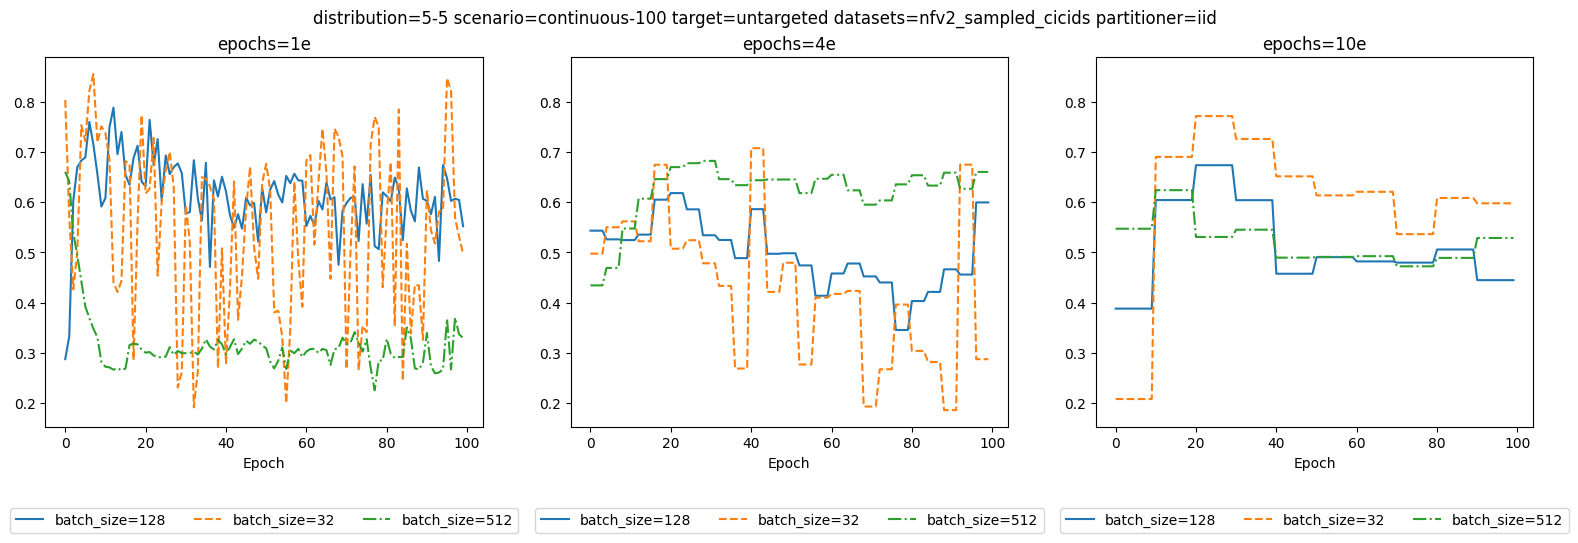

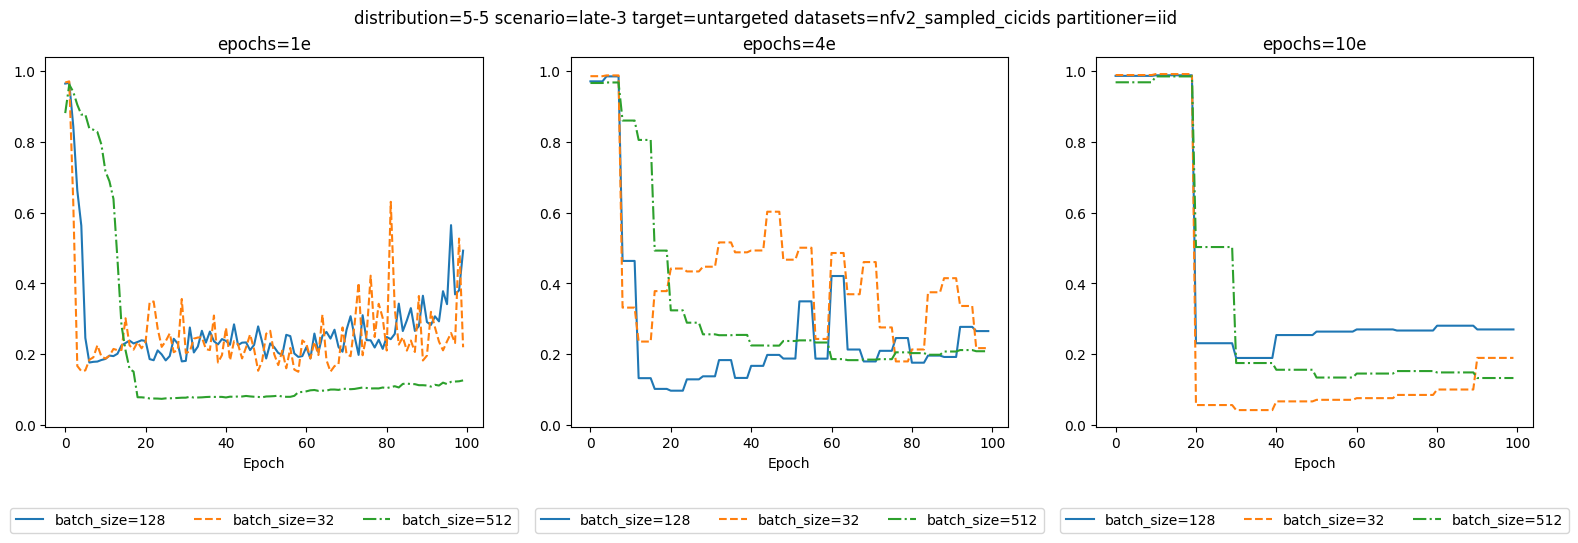

In [338]:
plot(
    load_metrics(
        *search_metrics(
            "results/sampled/megarun",
            scenario="continuous-100",
            distribution="5-5",
            target="untargeted",
            epochs="1e",
            datasets=".*cicids",
        ),
        metric="accuracy",
    ),
    load_metrics(
        *search_metrics(
            "results/sampled/megarun",
            scenario="continuous-100",
            distribution="5-5",
            target="untargeted",
            epochs="4e",
            datasets=".*cicids",
        ),
        metric="accuracy",
    ),
    load_metrics(
        *search_metrics(
            "results/sampled/megarun",
            scenario="continuous-100",
            distribution="5-5",
            target="untargeted",
            epochs="10e",
            datasets=".*cicids",
        ),
        metric="accuracy",
    ),
)
plot(
    load_metrics(
        *search_metrics(
            "results/sampled/megarun",
            scenario="late-3",
            distribution="5-5",
            target="untargeted",
            epochs="1e",
            datasets=".*cicids",
        ),
        metric="accuracy",
    ),
    load_metrics(
        *search_metrics(
            "results/sampled/megarun",
            scenario="late-3",
            distribution="5-5",
            target="untargeted",
            epochs="4e",
            datasets=".*cicids",
        ),
        metric="accuracy",
    ),
    load_metrics(
        *search_metrics(
            "results/sampled/megarun",
            scenario="late-3",
            distribution="5-5",
            target="untargeted",
            epochs="10e",
            datasets=".*cicids",
        ),
        metric="accuracy",
    ),
)

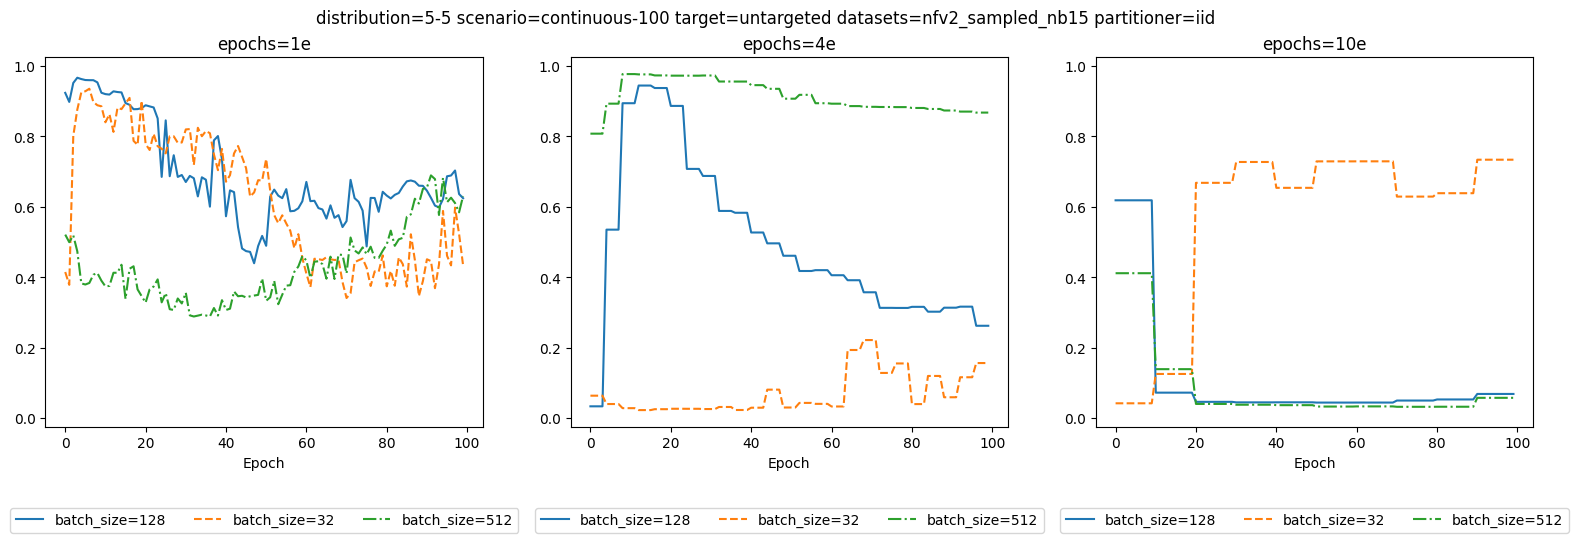

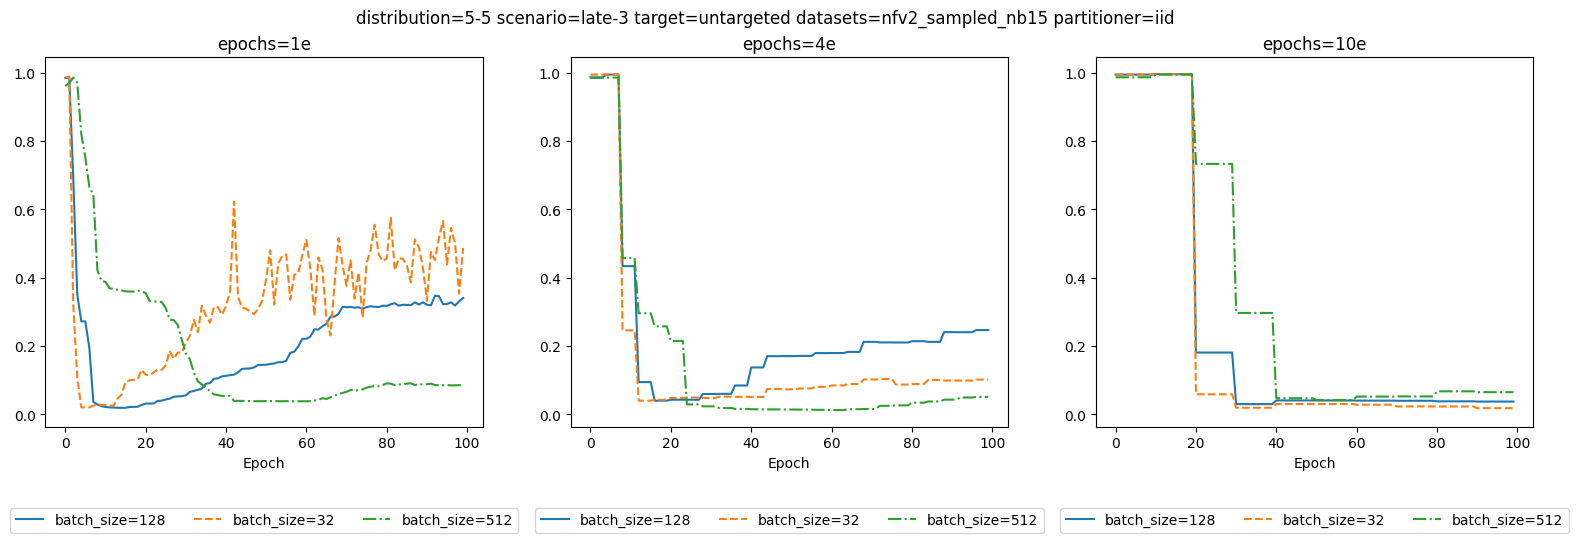

In [339]:
plot(
    load_metrics(
        *search_metrics(
            "results/sampled/megarun",
            scenario="continuous-100",
            distribution="5-5",
            target="untargeted",
            epochs="1e",
            datasets=".*nb15",
        ),
        metric="accuracy",
    ),
    load_metrics(
        *search_metrics(
            "results/sampled/megarun",
            scenario="continuous-100",
            distribution="5-5",
            target="untargeted",
            epochs="4e",
            datasets=".*nb15",
        ),
        metric="accuracy",
    ),
    load_metrics(
        *search_metrics(
            "results/sampled/megarun",
            scenario="continuous-100",
            distribution="5-5",
            target="untargeted",
            epochs="10e",
            datasets=".*nb15",
        ),
        metric="accuracy",
    ),
)
plot(
    load_metrics(
        *search_metrics(
            "results/sampled/megarun",
            scenario="late-3",
            distribution="5-5",
            target="untargeted",
            epochs="1e",
            datasets=".*nb15",
        ),
        metric="accuracy",
    ),
    load_metrics(
        *search_metrics(
            "results/sampled/megarun",
            scenario="late-3",
            distribution="5-5",
            target="untargeted",
            epochs="4e",
            datasets=".*nb15",
        ),
        metric="accuracy",
    ),
    load_metrics(
        *search_metrics(
            "results/sampled/megarun",
            scenario="late-3",
            distribution="5-5",
            target="untargeted",
            epochs="10e",
            datasets=".*nb15",
        ),
        metric="accuracy",
    ),
)

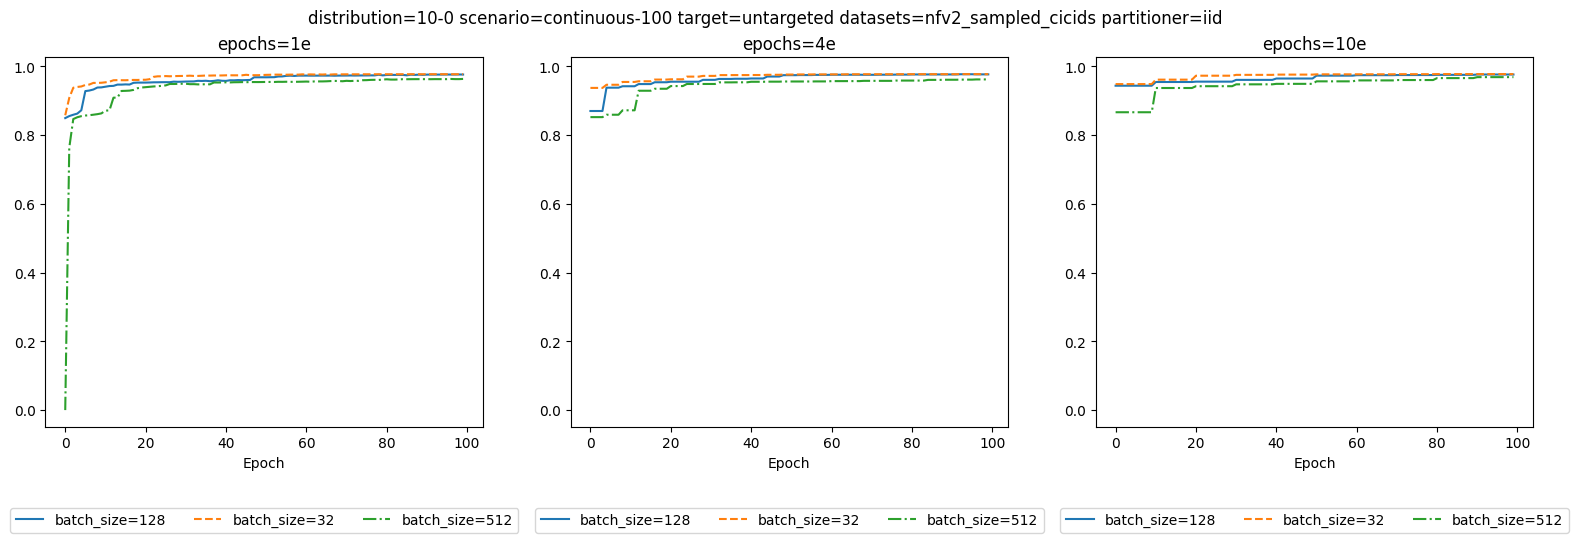

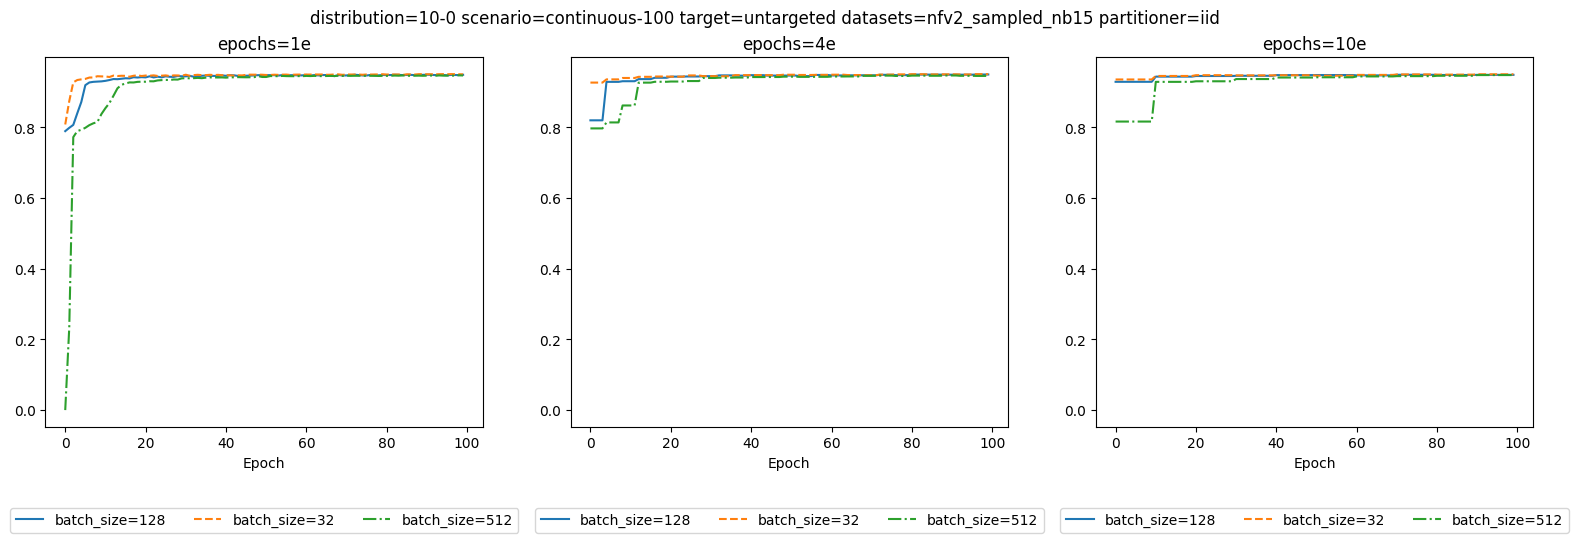

In [340]:
plot(
    load_metrics(
        *search_metrics(
            "results/sampled/megarun",
            scenario="continuous-100",
            distribution="10-0",
            target="untargeted",
            epochs="1e",
            datasets=".*cicids",
        ),
        metric="f1",
    ),
    load_metrics(
        *search_metrics(
            "results/sampled/megarun",
            scenario="continuous-100",
            distribution="10-0",
            target="untargeted",
            epochs="4e",
            datasets=".*cicids",
        ),
        metric="f1",
    ),
    load_metrics(
        *search_metrics(
            "results/sampled/megarun",
            scenario="continuous-100",
            distribution="10-0",
            target="untargeted",
            epochs="10e",
            datasets=".*cicids",
        ),
        metric="f1",
    ),
)
plot(
    load_metrics(
        *search_metrics(
            "results/sampled/megarun",
            scenario="continuous-100",
            distribution="10-0",
            target="untargeted",
            epochs="1e",
            datasets=".*nb15",
        ),
        metric="f1",
    ),
    load_metrics(
        *search_metrics(
            "results/sampled/megarun",
            scenario="continuous-100",
            distribution="10-0",
            target="untargeted",
            epochs="4e",
            datasets=".*nb15",
        ),
        metric="f1",
    ),
    load_metrics(
        *search_metrics(
            "results/sampled/megarun",
            scenario="continuous-100",
            distribution="10-0",
            target="untargeted",
            epochs="10e",
            datasets=".*nb15",
        ),
        metric="f1",
    ),
)

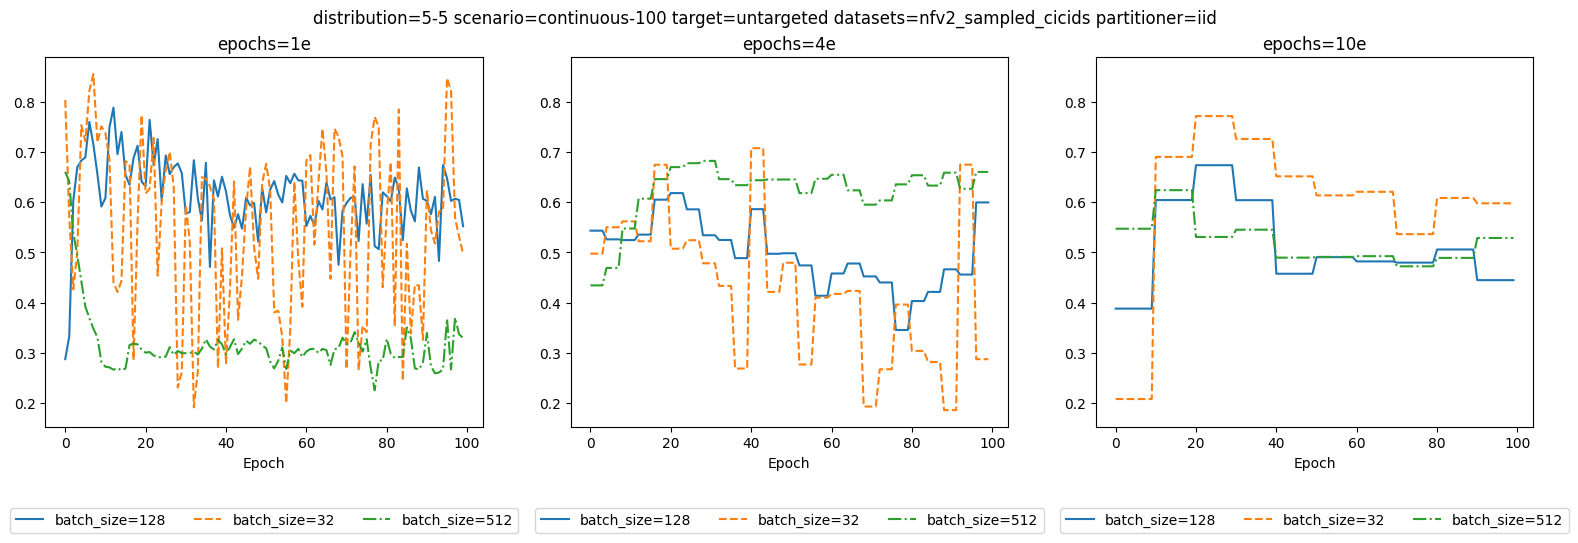

In [341]:
plot(
    load_metrics(
        *search_metrics(
            "results/sampled/megarun",
            scenario="continuous-100",
            distribution="5-5",
            target="untargeted",
            epochs="1e",
            datasets=".*cicids",
        ),
        metric="accuracy",
    ),
    load_metrics(
        *search_metrics(
            "results/sampled/megarun",
            scenario="continuous-100",
            distribution="5-5",
            target="untargeted",
            epochs="4e",
            datasets=".*cicids",
        ),
        metric="accuracy",
    ),
    load_metrics(
        *search_metrics(
            "results/sampled/megarun",
            scenario="continuous-100",
            distribution="5-5",
            target="untargeted",
            epochs="10e",
            datasets=".*cicids",
        ),
        metric="accuracy",
    ),
)

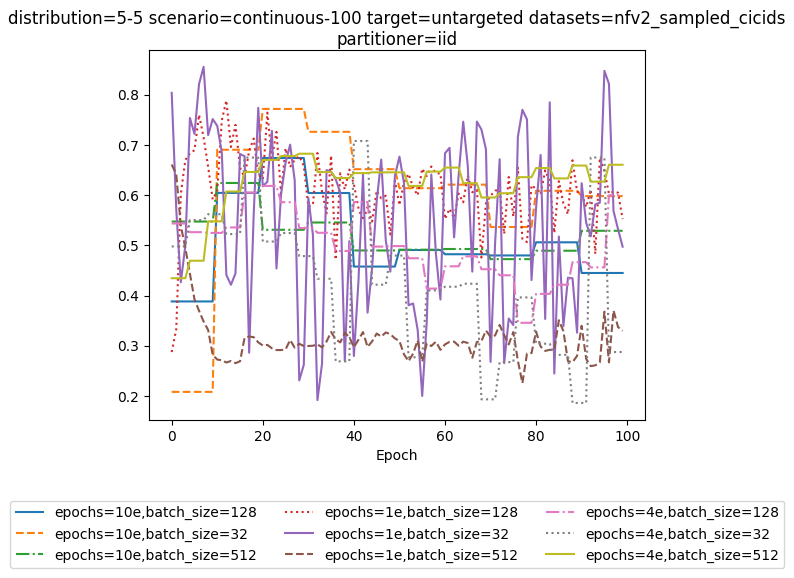

In [342]:
plot(
    load_metrics(
        *search_metrics(
            "results/sampled/megarun",
            scenario="continuous-100",
            distribution="5-5",
            target="untargeted",
            datasets=".*cicids",
        ),
    ),
)

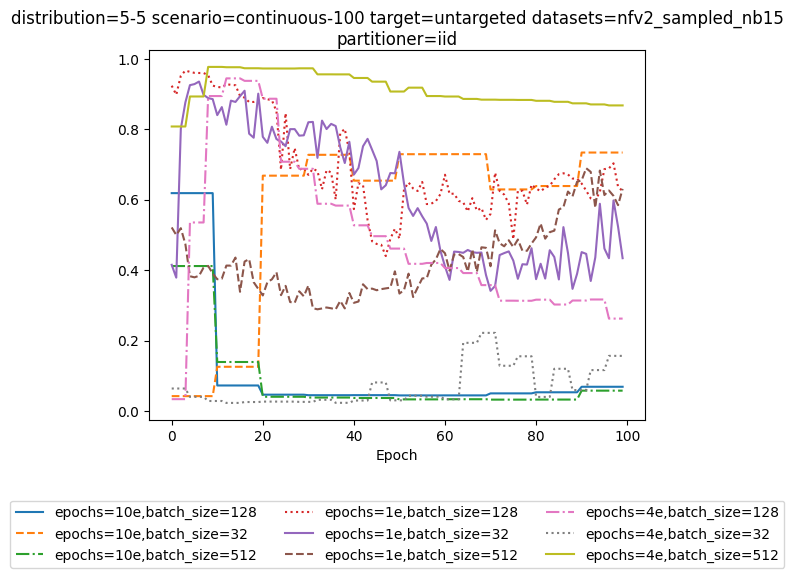

In [343]:
plot(
    load_metrics(
        *search_metrics(
            "results/sampled/megarun",
            scenario="continuous-100",
            distribution="5-5",
            target="untargeted",
            datasets=".*nb15",
        ),
    ),
)

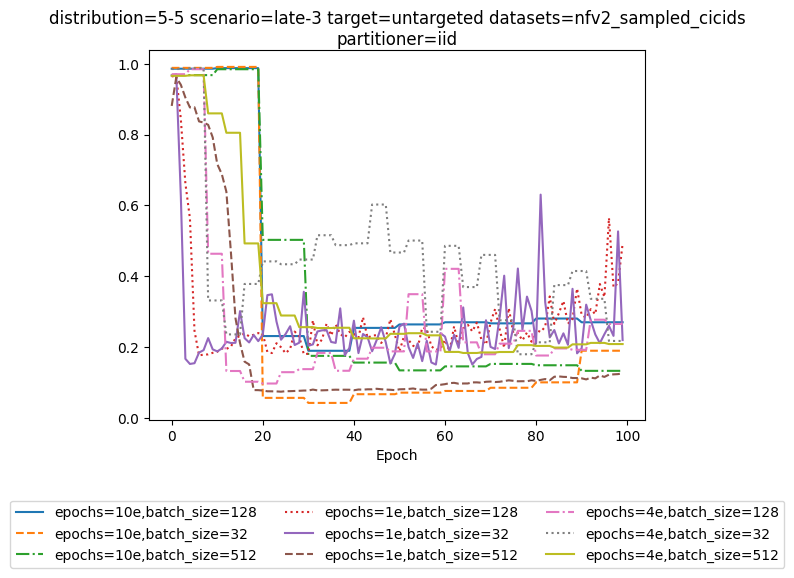

In [344]:
plot(
    load_metrics(
        *search_metrics(
            "results/sampled/megarun",
            scenario="late-3",
            distribution="5-5",
            target="untargeted",
            datasets=".*cicids",
        ),
    ),
)

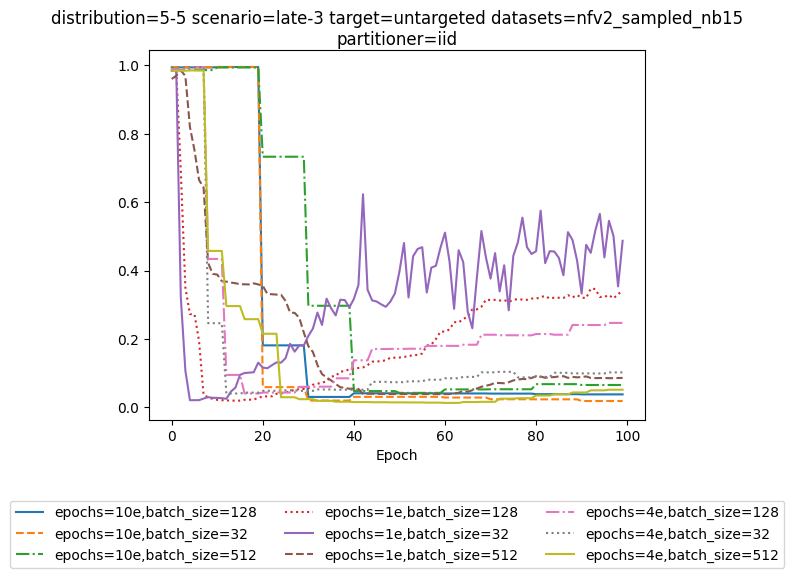

In [345]:
plot(
    load_metrics(
        *search_metrics(
            "results/sampled/megarun",
            scenario="late-3",
            distribution="5-5",
            target="untargeted",
            datasets=".*nb15",
        ),
    ),
)